# Tree Census Final Project

## Packages

In [5]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix, precision_recall_fscore_support, make_scorer, classification_report
from geopandas import GeoDataFrame
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from shapely.geometry import Point, Polygon

warnings.filterwarnings('ignore')

## Exploratory Data Analysis and Visualization

In [4]:
# load in data with relative path
tree_df = pd.read_csv('2015_Street_Tree_Census_-_Tree_Data.csv')

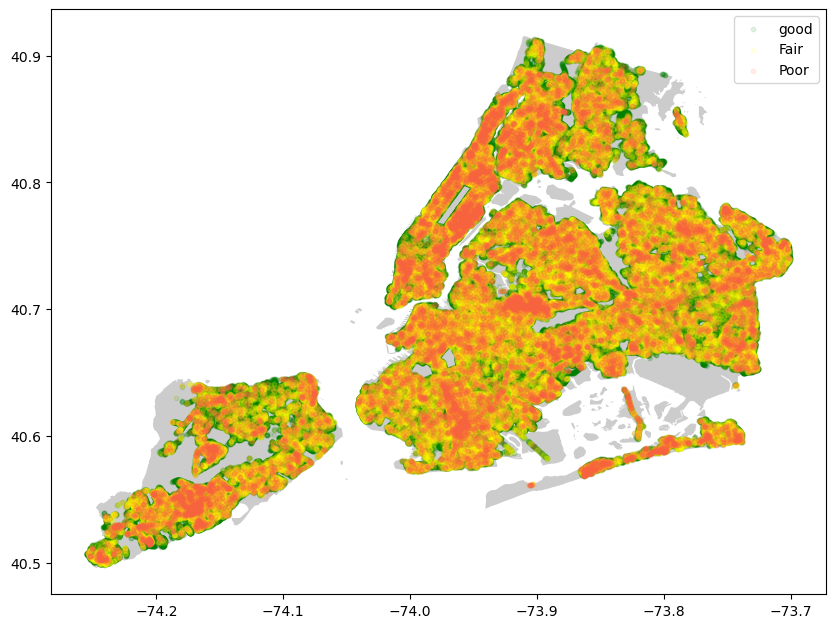

In [6]:
# create geo dataframe
geometry = [Point(xy) for xy in zip(tree_df['longitude'], tree_df['latitude'])]
gdf = GeoDataFrame(tree_df[['health', 'longitude', 'latitude']], geometry=geometry)
#%% 2.3 map 
## source:
# https://geopandas.org/en/stable/docs/user_guide/geocoding.html

# get map of NY
ny_map = gpd.read_file(gpd.datasets.get_path('nybb'))
# plot
alpha = 0.1
markersize = 10
fig,ax=plt.subplots(figsize=(10,10))
ny_map.to_crs("EPSG:4326").plot(ax=ax,alpha=0.4,color="grey")
gdf[gdf['health']=="Good"].plot(ax=ax,markersize=markersize, alpha=alpha,color="green", label="good")
gdf[gdf['health']=="Fair"].plot(ax=ax,markersize=markersize, alpha=alpha,color="yellow", label="Fair")
gdf[gdf['health']=="Poor"].plot(ax=ax,markersize=markersize, alpha=alpha,color="tomato", label="Poor")
plt.legend()
plt.show()

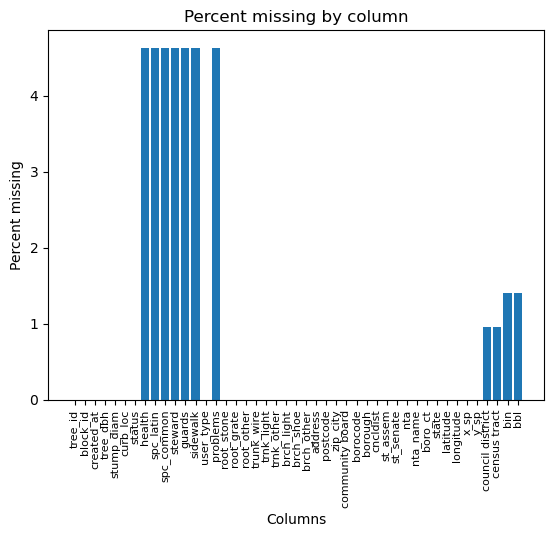

In [7]:
# plot missing values by columns
vals = (tree_df.isna().sum() * 100 / len(tree_df)).values
keys = tree_df.columns
plt.tight_layout()
plt.bar(keys, vals)
plt.xlabel("Columns")
plt.ylabel("Percent missing")
plt.xticks(rotation=90, fontsize=8)
plt.title("Percent missing by column")
plt.show()

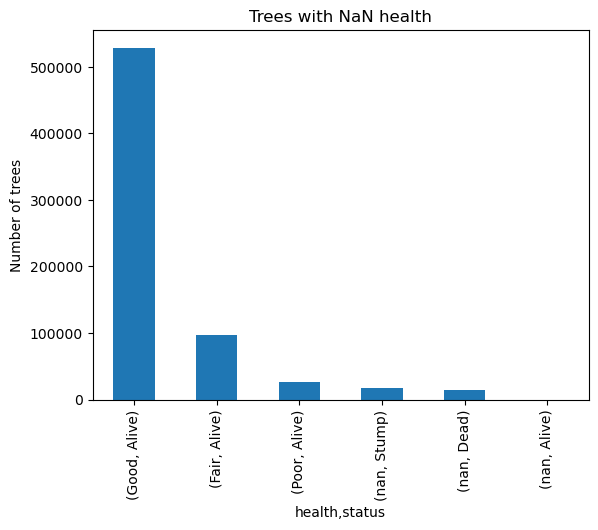

In [8]:
# plot NA values by health status
tree_df[['health', 'status']].value_counts(dropna=False).plot(kind='bar')
plt.title('Trees with NaN health')
plt.ylabel("Number of trees")
plt.show()

In [9]:
# drop dead trees that appear as NA
tree_df_clean = tree_df[tree_df['health'].notna()]
print("Dead or stumps:", tree_df.shape[0] - tree_df_clean.shape[0])

Dead or stumps: 31616


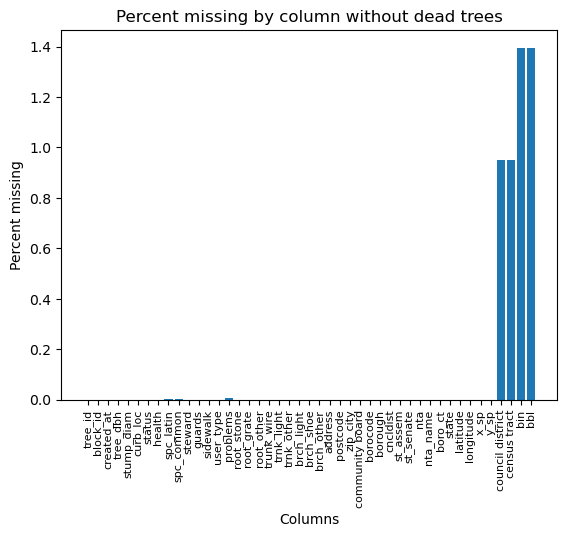

In [10]:
# other NA values
vals = (tree_df_clean.isna().sum() * 100 / len(tree_df_clean)).values
keys = tree_df_clean.columns
plt.tight_layout()
plt.bar(keys, vals)
plt.xlabel("Columns")
plt.ylabel("Percent missing")
plt.xticks(rotation=90, fontsize=8)
plt.title("Percent missing by column without dead trees")
plt.show()

In [11]:
'''
Dropped columns:
- borocode and boro_ct, equivalent to borough
- x_sp and y_sp - use latitude and longitude instead
- state - identical for all
- nta_name, equivalent to nta
- zip_city, directly correlated to postcode
- address, estimated from latitude and longitude
- spc_latin, equivalent to spc_common
- created_at, not helpful (time data was added)
- tree_id, not helpful (unique identifier)
- block_id, not helpful (geo location)
- user_type, not helpful (which volunteer analyzed it)
- bin, not helpful (building identifier)
- bbl, not helpful (block identifier)
- council district, equivalent to cncldist
- census tract, missing values and other location data
- problems, one-hot encoded in other values
- status, all are alive after dropping dead and stumps
- stump_diam, only applies to stumps
'''
tree_df_dropped = tree_df_clean.drop(columns=[
    'borocode', 'x_sp', 'y_sp', 'state', 'nta_name', 'zip_city', 'address',
    'spc_latin', 'created_at', 'tree_id', 'block_id', 'user_type', 'bin',
    'bbl', 'council district', 'boro_ct', 'census tract', 'problems', 'status',
    'stump_diam'
])

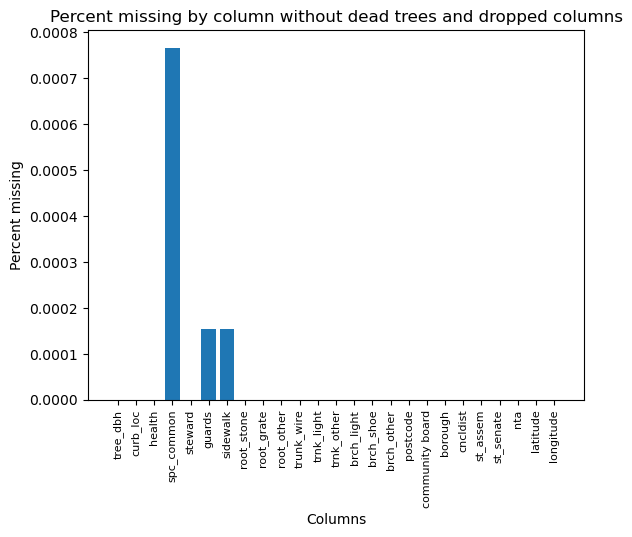

In [12]:
# remianing NA values
vals = (tree_df_dropped.isna().sum() * 100 / len(tree_df_dropped)).values
keys = tree_df_dropped.columns
plt.tight_layout()
plt.bar(keys, vals)
plt.xlabel("Columns")
plt.ylabel("Percent missing")
plt.xticks(rotation=90, fontsize=8)
plt.title("Percent missing by column without dead trees and dropped columns")
plt.show()

In [13]:
# drop those rows since so few missing
tree_df_processed = tree_df_dropped.dropna(how='any')
print("Trees with missing values:", tree_df_dropped.shape[0] - tree_df_processed.shape[0])
miss_val = tree_df_processed.shape[0]

Trees with missing values: 6


In [14]:
# drop invalid zipcode
tree_df_processed = tree_df_processed[tree_df_processed['postcode'] != 83]

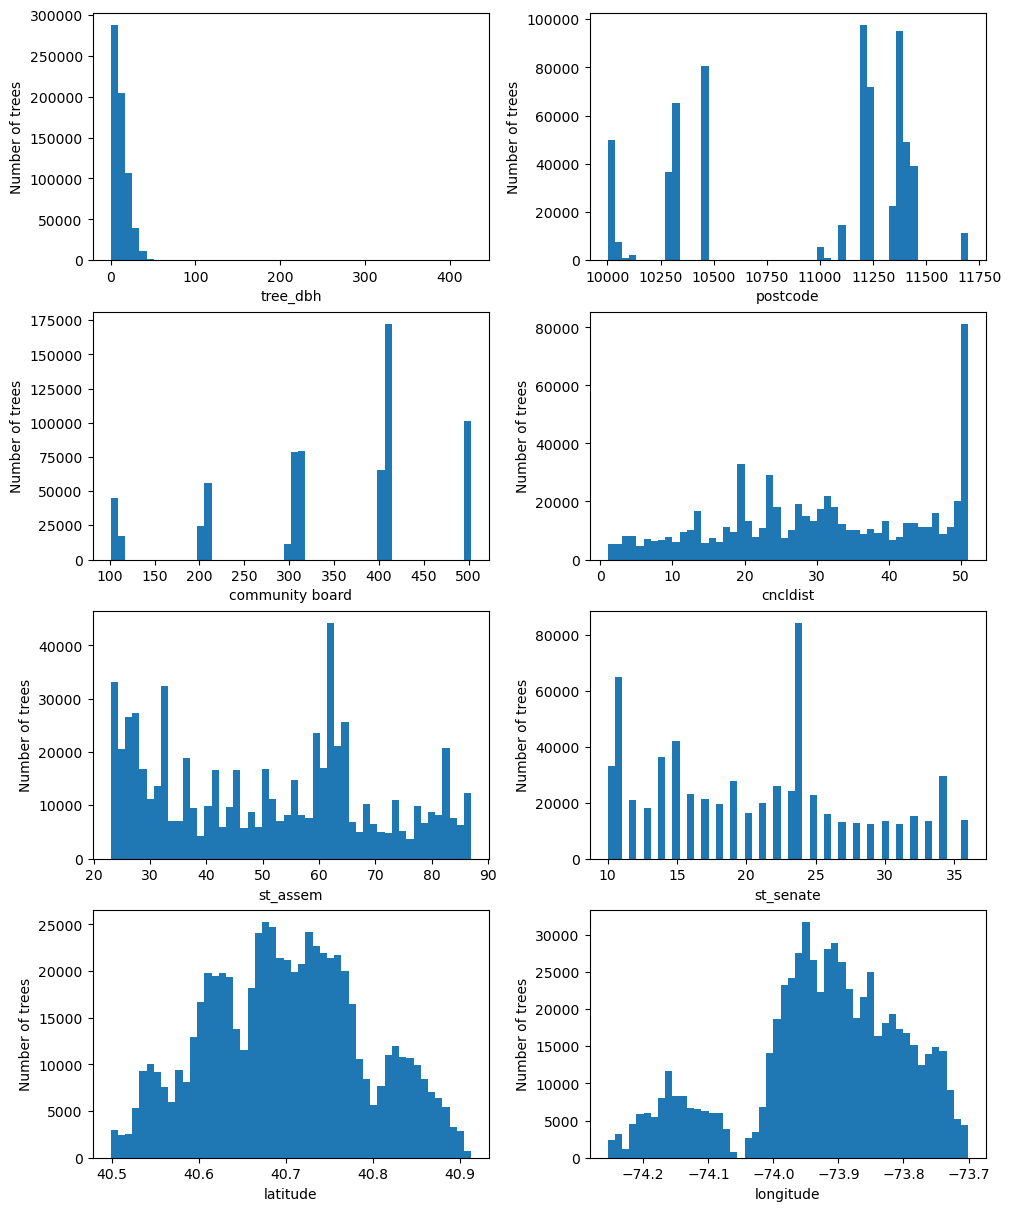

In [15]:
# plot each quantitaive feature
vals = [
    'tree_dbh', 'postcode', 'community board', 'cncldist', 'st_assem',
    'st_senate', 'latitude', 'longitude'
]

fig, axs = plt.subplots(len(vals) // 2, 2, figsize=(10, 12), constrained_layout=True)

for i, val in enumerate(vals):
    axs[i // 2, i % 2].hist(tree_df_processed[val], bins=50)
    axs[i // 2, i % 2].set(xlabel=val, ylabel="Number of trees")

plt.show()

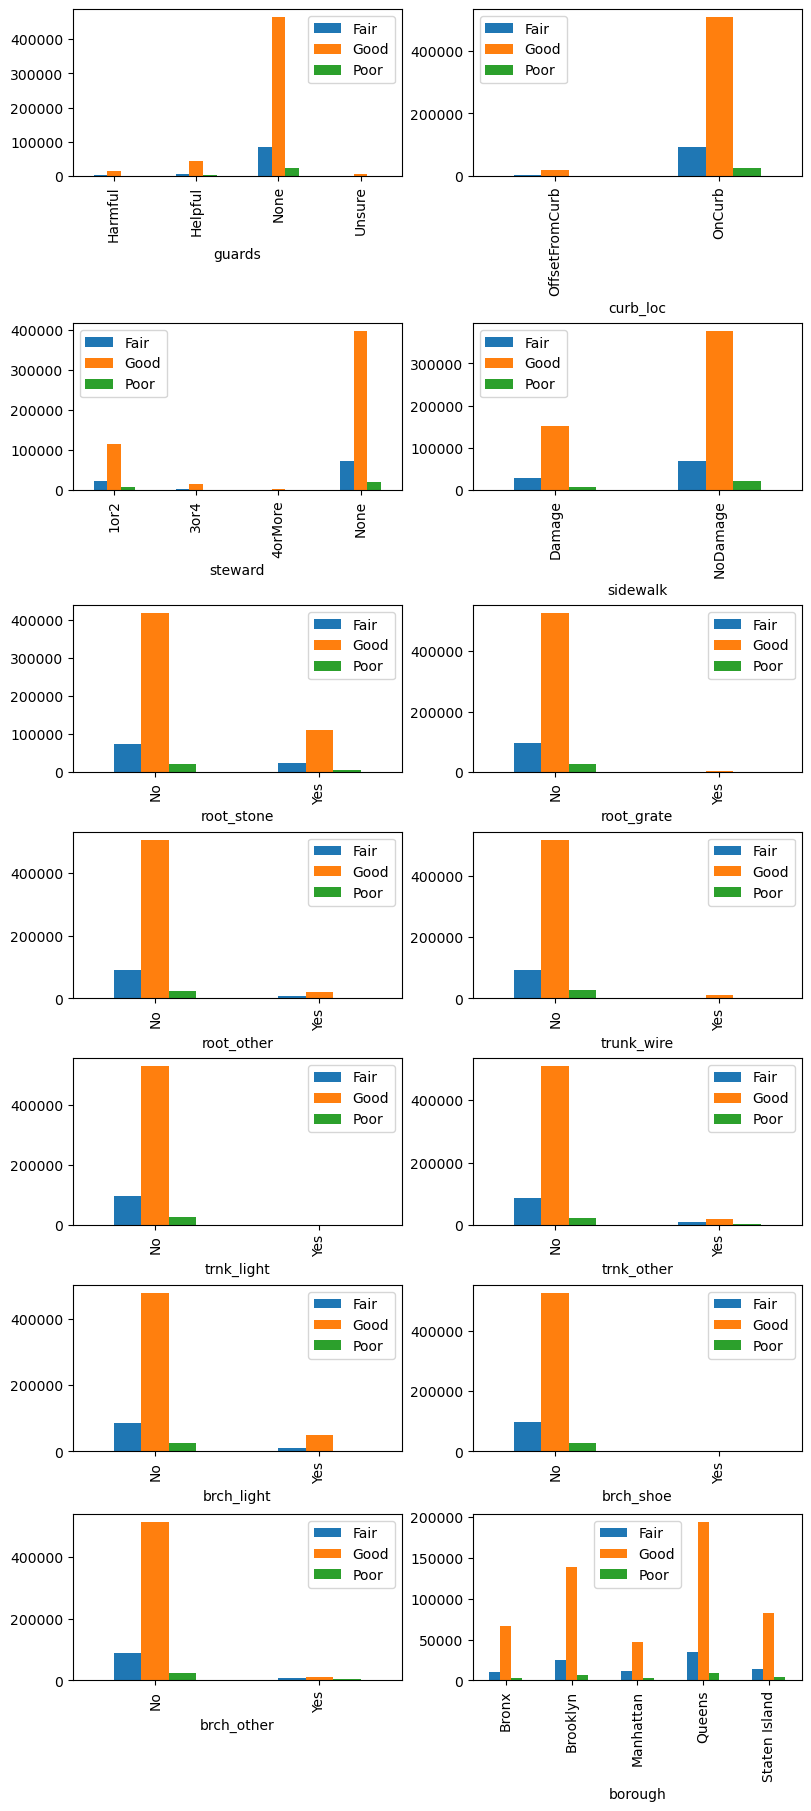

In [16]:
# plot each categorical feature realtive to the health of the tree
def cat_plot(feature, ax):
    df = tree_df_processed[['health', feature]].value_counts().to_frame()
    df = df.unstack(level=0)
    df.columns = ['Fair', 'Good', 'Poor']
    df.plot(kind='bar', ax=ax)

vals = [
    'guards', 'curb_loc', 'steward', 'sidewalk', 'root_stone', 'root_grate',
    'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe',
    'brch_other', 'borough'
]
    
fig, axs = plt.subplots(len(vals) // 2, 2, figsize=(8, 18), constrained_layout=True)

for i, val in enumerate(vals):
    cat_plot(val, axs[i // 2, i % 2])

plt.show()

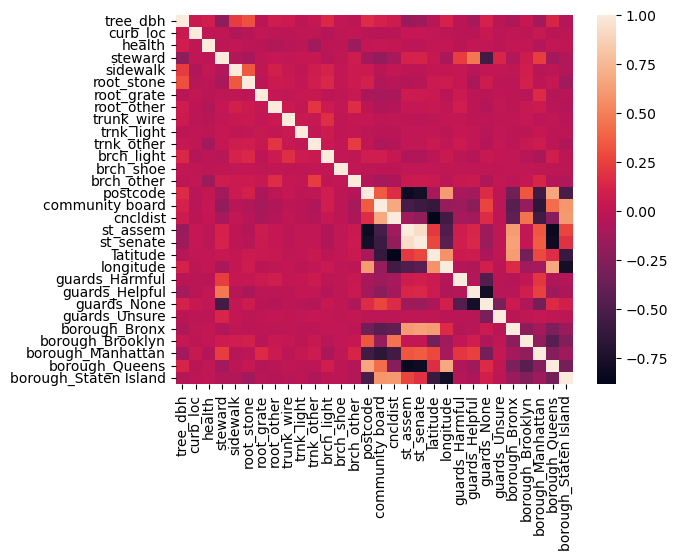

In [17]:
# look for multicolinearity
# Ordinal encoding
tree_df_encoded = tree_df_processed.copy(deep=True)

health = ['Poor', 'Fair', 'Good']
enc = OrdinalEncoder(categories=[health])
tree_df_encoded['health'] = enc.fit_transform(tree_df_processed[['health']])

steward = ['None', '1or2', '3or4', '4orMore']
enc = OrdinalEncoder(categories=[steward])
tree_df_encoded['steward'] = enc.fit_transform(tree_df_encoded[['steward']])

sidewalk = ['NoDamage', 'Damage']
enc = OrdinalEncoder(categories=[sidewalk])
tree_df_encoded['sidewalk'] = enc.fit_transform(tree_df_encoded[['sidewalk']])

curbloc = ['OnCurb', 'OffsetFromCurb']
enc = OrdinalEncoder(categories=[curbloc])
tree_df_encoded['curb_loc'] = enc.fit_transform(tree_df_encoded[['curb_loc']])

yes_no = ['No', 'Yes']
enc = OrdinalEncoder(categories=[yes_no])

yes_no_features = [
    'brch_other', 'brch_shoe', 'brch_light', 'trnk_other', 'trnk_light',
    'trunk_wire', 'root_other', 'root_grate', 'root_stone'
]

for feat in yes_no_features:
    tree_df_encoded[feat] = enc.fit_transform(tree_df_encoded[[feat]])
    
# One-hot encode
enc = OneHotEncoder()
guards = enc.fit_transform(tree_df_encoded[['guards']])
tree_df_encoded['guards_' + enc.categories_[0][:]] = guards.toarray()
tree_df_encoded = tree_df_encoded.drop(columns=['guards'])

guards = enc.fit_transform(tree_df_encoded[['borough']])
tree_df_encoded['borough_' + enc.categories_[0][:]] = guards.toarray()
tree_df_encoded = tree_df_encoded.drop(columns=['borough'])

corr = tree_df_encoded.corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [18]:
# check species feature for usability
tree_df_encoded['spc_common'].value_counts()

London planetree    86960
honeylocust         64254
Callery pear        58928
pin oak             52971
Norway maple        34189
                    ...  
black pine             37
pitch pine             33
Osage-orange           29
Scots pine             25
Virginia pine          10
Name: spc_common, Length: 132, dtype: int64

We can see that there are too many species to make use of, so we can drop them in the preprocessing

## Preprocessing

In [19]:
# drop columns that arent useful, or suffer from multicolinearity
tree_df = tree_df.drop(columns=[
    'borocode', 'x_sp', 'y_sp', 'state', 'nta_name', 'zip_city', 'address',
    'spc_latin', 'created_at', 'tree_id', 'block_id', 'user_type', 'bin',
    'bbl', 'council district', 'boro_ct', 'census tract', 'problems', 'status',
    'stump_diam', 'postcode', 'community board', 'cncldist', 'st_assem', 'st_senate', 
    'nta', 'spc_common'
])

In [20]:
# drop NA and dead tree values
tree_df = tree_df[tree_df['health'].notna()]
tree_df = tree_df.dropna(how='any')

In [21]:
# scale diameters (only continuos numerical feature left)
scaler = StandardScaler()
tree_df['tree_dbh'] = scaler.fit_transform(tree_df[['tree_dbh']])

In [22]:
# Ordinal Encode (categorical hierarchal features)
health = ['Poor', 'Fair', 'Good']
enc = OrdinalEncoder(categories=[health])
tree_df['health'] = enc.fit_transform(tree_df[['health']])

steward = ['None', '1or2', '3or4', '4orMore']
enc = OrdinalEncoder(categories=[steward])
tree_df['steward'] = enc.fit_transform(tree_df[['steward']])

sidewalk = ['NoDamage', 'Damage']
enc = OrdinalEncoder(categories=[sidewalk])
tree_df['sidewalk'] = enc.fit_transform(tree_df[['sidewalk']])

curbloc = ['OnCurb', 'OffsetFromCurb']
enc = OrdinalEncoder(categories=[curbloc])
tree_df['curb_loc'] = enc.fit_transform(tree_df[['curb_loc']])

yes_no = ['No', 'Yes']
enc = OrdinalEncoder(categories=[yes_no])

yes_no_features = [
    'brch_other', 'brch_shoe', 'brch_light', 'trnk_other', 'trnk_light',
    'trunk_wire', 'root_other', 'root_grate', 'root_stone'
]

for feat in yes_no_features:
    tree_df[feat] = enc.fit_transform(tree_df[[feat]])
    
# One Hot Encode (non-hierarchal categorical features)
enc = OneHotEncoder()
guards = enc.fit_transform(tree_df[['guards']])
tree_df['guards_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['guards'])

guards = enc.fit_transform(tree_df[['borough']])
tree_df['borough_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['borough'])

In [23]:
# split to x and y sets
y = np.asarray(tree_df['health'])
x = tree_df.drop(columns=['health'])

In [24]:
# random sample (stratified) for dev, test, train and val
x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=42, stratify = y_dev)

In [25]:
# over-sampling of training data
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(x_train, y_train)

In [26]:
# under sampling of training data
rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x_train, y_train)

In [27]:
# smote sampling of training data
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

## Decision Tree

Selected hyperparameters:  

max_depth: The maximum depth of the tree. 

min_samples_split: The minimum number of samples required to split an internal node. 

max_features: Number of features to consider when looking for the best split. 

Max_leaf_nodes: Maximum number of leaf nodes a decision tree can have. 

ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning


In [1]:
# function to evaluate the model
"""
  print decsion tree model result.
      Args:
          model: decision tree model
          X_train: training data of X.
          y_train: training data of y.
          X_test: testing data of X.   
          y_test: testing data of y.
      Returns:
          Print confusion matrix and classification report.
"""

def model_result(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    # confusion_matrix
    cf = confusion_matrix(y_test, model.predict(x_test))
    sns.heatmap(cf, annot = True, fmt = 'g')
    plt.show()
    # result plot
    print(classification_report(y_test, model.predict(x_test)))

In [2]:
# function to fit and tune the model
def dt_select(x_train, y_train, score):
    # possible values for the model to be tuned on
    param_grid = {
        'max_depth': [4, 8, 10, 12, 15, 20],
        'min_samples_split': np.linspace(0.1, 0.3, 3, endpoint=True),
        "max_features": ["log2", "sqrt", None],
        "max_leaf_nodes": [None, 10, 20, 30],
        'ccp_alpha': np.logspace(-6, -4, 3)
    }

    # create a base model
    dt = DecisionTreeClassifier(random_state=100)

    # initantiate the random search model based on parameters defined above
    randomized_search = RandomizedSearchCV(estimator=dt,
                                           param_distributions=param_grid,
                                           scoring=score,
                                           cv=5,
                                           random_state=100)

    randomized_model = randomized_search.fit(x_train, y_train)
    return randomized_model

In [ ]:
#plot feature importance

def feature_importance(x_train, model):
  features = x_train.columns.values
  plt.figure(figsize = (12, 6))
  feat_imps = zip(features, model.best_estimator_.feature_importances_)
  feats,imps = zip(*(sorted(list(filter(lambda x: x[1] != 0 , feat_imps)), key=lambda x: x[1], reverse=True)))
  ax = sns.barplot(x = list(feats), y = list(imps))
  ax.tick_params(axis = 'x', rotation = 90)

### Decision Tree for random stratified sampling

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-06}
optimal score 0.8109073571767318
test score 0.8109081987825261


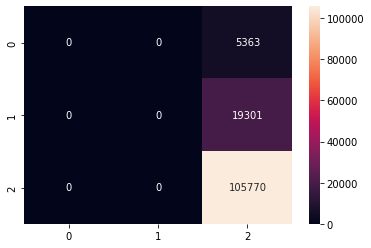

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [15]:

# accuracy as scoring metric
random_best = dt_select(x_train,y_train,'accuracy')
print("optimal hyperparameters",random_best.best_params_)
print("optimal score", random_best.best_score_)
print("test score",random_best.score(x_test,y_test))

#recall as metric for hyperparamter tuning
model_result(random_best, x_train, y_train, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-06}
optimal score 0.3333333333333333
test score 0.3333333333333333


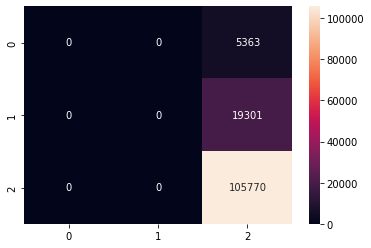

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [16]:
# random stratified sampling
# recall as scoring metric
random_best = dt_select(x_train,y_train,'recall_macro')
print("optimal hyperparameters",random_best.best_params_)
print("optimal score", random_best.best_score_)
print("test score",random_best.score(x_test,y_test))

#recall as metric for hyperparamter tuning
model_result(random_best, x_train, y_train, x_test, y_test)



optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-06}
optimal f1 score 0.29852709065529426
test f1 score 0.2985272617454969


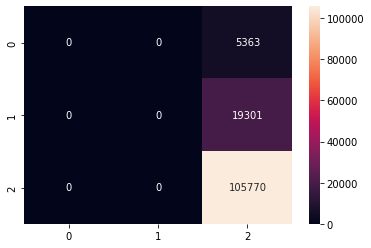

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [17]:
#f1 as scoring metric
random_best = dt_select(x_train,y_train,'f1_macro')
print("optimal hyperparameters",random_best.best_params_)
print("optimal f1 score", random_best.best_score_)
print("test f1 score",random_best.score(x_test,y_test))
#f1 as metric for hyperparamter tuning
model_result(random_best, x_train, y_train, x_test, y_test)

### Decision Tree for random over sampling

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal score 0.42521139435335636
test score 0.4216232268146592


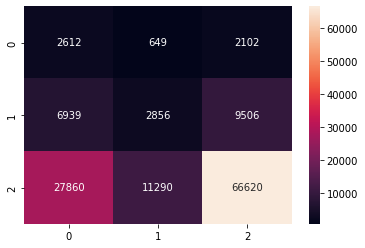

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.19      0.15      0.17     19301
         2.0       0.85      0.63      0.72    105770

    accuracy                           0.55    130434
   macro avg       0.37      0.42      0.34    130434
weighted avg       0.72      0.55      0.62    130434



In [18]:
# recall as scoring metric
over_best_recall = dt_select(x_ros, y_ros,'recall_macro')
print("optimal hyperparameters",over_best_recall.best_params_)
print("optimal score", over_best_recall.best_score_)
print("test score",over_best_recall.score(x_test,y_test))

# recallmacro as metric for hyperparamter tuning
model_result(over_best_recall, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal accuracy score 0.4252114213595847
test accuracy 0.552677982734563


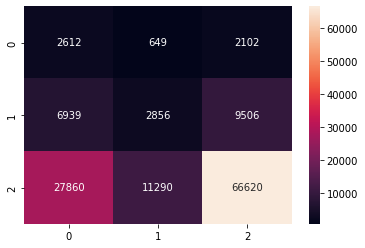

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.19      0.15      0.17     19301
         2.0       0.85      0.63      0.72    105770

    accuracy                           0.55    130434
   macro avg       0.37      0.42      0.34    130434
weighted avg       0.72      0.55      0.62    130434



In [19]:
# accuracy as score metric
over_best_acc = dt_select(x_ros, y_ros,'accuracy')
print("optimal hyperparameters",over_best_acc.best_params_)
print("optimal accuracy score", over_best_acc.best_score_)
print("test accuracy",over_best_acc.score(x_test,y_test))

# as metric for hyperparamter tuning
model_result(over_best_acc, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-06}
optimal f1 score 0.40025096917702496
test f1 score 0.3201379887339995


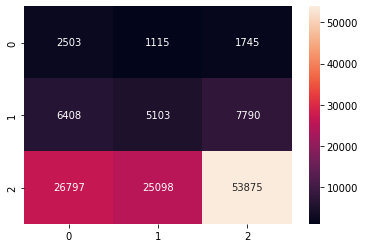

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.16      0.26      0.20     19301
         2.0       0.85      0.51      0.64    105770

    accuracy                           0.47    130434
   macro avg       0.36      0.41      0.32    130434
weighted avg       0.72      0.47      0.55    130434



In [20]:
# f1 as score metric
over_best_f1 = dt_select(x_ros, y_ros,'f1_macro')
print("optimal hyperparameters",over_best_f1.best_params_)
print("optimal f1 score", over_best_f1.best_score_)
print("test f1 score",over_best_f1.score(x_test,y_test))

#f1 as metric for hyperparamter tuning
model_result(over_best_f1, x_ros, y_ros, x_test, y_test)

### Decision Tree for random under sampling

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal accuracy score 0.42282814886132025
test accuracy score 0.5130334115338026


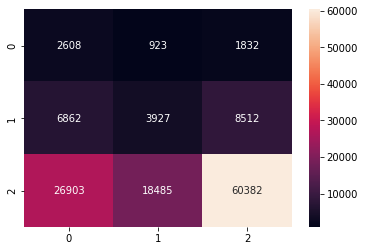

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.17      0.20      0.18     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.36      0.42      0.33    130434
weighted avg       0.72      0.51      0.59    130434



In [21]:
# random under sampling
# accuracy as scoring metric

under_best_acc = dt_select(x_rus, y_rus,'accuracy')
print("optimal hyperparameters",under_best_acc.best_params_)
print("optimal accuracy score", under_best_acc.best_score_)
print("test accuracy score",under_best_acc.score(x_test,y_test))
# accuracy as metric for hyperparamter pruning
model_result(under_best_acc, x_rus, y_rus, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal recall score 0.4228293714894356
test recall score 0.4202120521676436


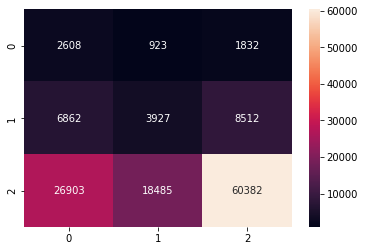

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.17      0.20      0.18     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.36      0.42      0.33    130434
weighted avg       0.72      0.51      0.59    130434



In [22]:

# recall as scoring metric
under_best_recall = dt_select(x_rus, y_rus,'recall_macro')
print("optimal hyperparameters",under_best_recall.best_params_)
print("optimal recall score", under_best_recall.best_score_)
print("test recall score",under_best_recall.score(x_test,y_test))

# recall as metric for hyperparamter tuning
model_result(under_best_recall, x_rus, y_rus, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal f1 score 0.4097896911316369
test f1 score 0.3311391234276632


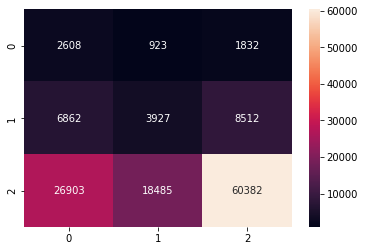

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.17      0.20      0.18     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.36      0.42      0.33    130434
weighted avg       0.72      0.51      0.59    130434



In [24]:
# f1 as score metric
under_best_f1 = dt_select(x_rus, y_rus,'f1_macro')
print("optimal hyperparameters",under_best_f1.best_params_)
print("optimal f1 score", under_best_f1.best_score_)
print("test f1 score",under_best_f1.score(x_test,y_test))
# f1 as metric for hyperparamter pruning
model_result(under_best_f1, x_rus, y_rus, x_test, y_test)

### Decison Tree for smote sampling

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal recall score 0.42784390717769993
test recall score 0.41559624496818587


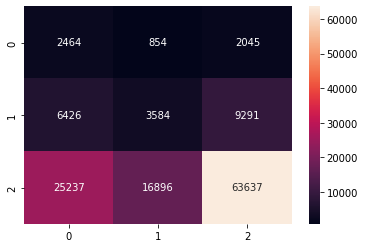

              precision    recall  f1-score   support

         0.0       0.07      0.46      0.12      5363
         1.0       0.17      0.19      0.18     19301
         2.0       0.85      0.60      0.70    105770

    accuracy                           0.53    130434
   macro avg       0.36      0.42      0.34    130434
weighted avg       0.72      0.53      0.60    130434



In [25]:

# recall as metric
smote_best = dt_select(x_smote, y_smote,"recall_macro")
print("optimal hyperparameters",smote_best.best_params_)
print("optimal recall score", smote_best.best_score_)
print("test recall score",smote_best.score(x_test,y_test))

#recall as metric for hyperparamter pruning
model_result(smote_best, x_smote, y_smote, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal score 0.427843910192804
test score 0.5342548721958998


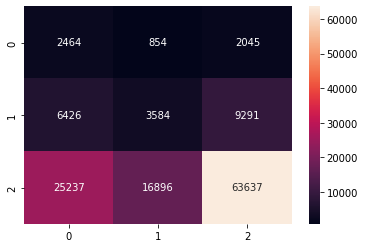

              precision    recall  f1-score   support

         0.0       0.07      0.46      0.12      5363
         1.0       0.17      0.19      0.18     19301
         2.0       0.85      0.60      0.70    105770

    accuracy                           0.53    130434
   macro avg       0.36      0.42      0.34    130434
weighted avg       0.72      0.53      0.60    130434



In [26]:
# accuracy as metric
smote_best_acc = dt_select(x_smote, y_smote,"accuracy")
print("optimal hyperparameters",smote_best_acc.best_params_)
print("optimal score", smote_best_acc.best_score_)
print("test score",smote_best_acc.score(x_test,y_test))

#accuracy as metric for hyperparamter pruning
model_result(smote_best_acc, x_smote, y_smote, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal f1 score 0.4084079737595042
test f1 score 0.33512061923807873


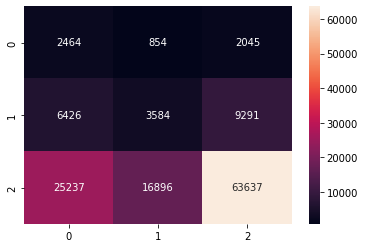

              precision    recall  f1-score   support

         0.0       0.07      0.46      0.12      5363
         1.0       0.17      0.19      0.18     19301
         2.0       0.85      0.60      0.70    105770

    accuracy                           0.53    130434
   macro avg       0.36      0.42      0.34    130434
weighted avg       0.72      0.53      0.60    130434



In [27]:
# f1 sccore as metric
smote_best_f1 = dt_select(x_smote, y_smote,'f1_macro')
print("optimal hyperparameters",smote_best_f1.best_params_)
print("optimal f1 score", smote_best_f1.best_score_)
print("test f1 score",smote_best_f1.score(x_test,y_test))
# f1 as metric for hyperparamter pruning
model_result(smote_best_f1, x_smote, y_smote, x_test, y_test)



overall, recall as a scoring metric for tunning is best for predicting bad and fair trees well.

under sampling is best in having highest recall in poor and fair trees, which means have highest rate in predicting correct poor and fair trees.

### Decision tree: feature importance

print feature importance plot for the best model: under sampling method

optimal hyperparameters: `{'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}`

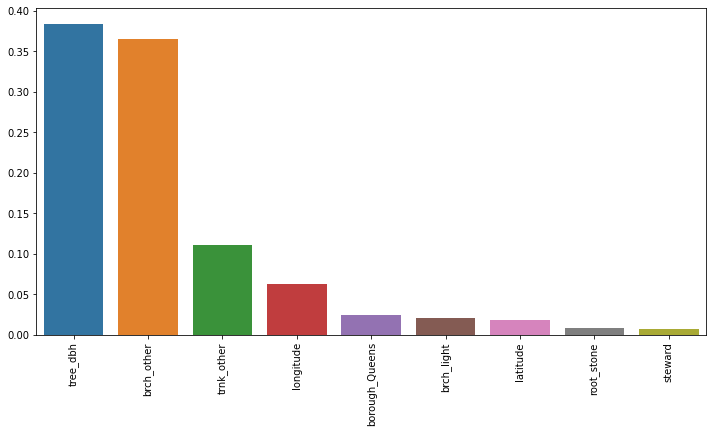

In [48]:
feature_importance(x_rus, under_best_recall)

## SVM

In [61]:
## svm model

"""
A short cut to print the svm model result.
    Args:
        svm: the svm model.
        X_train: training data of X.
        y_train: training data of y.
        X_test: testing data of X.   
        y_test: testing data of y.
        report_test: boolean; print the classification report of testing data if true, default as True.
        report_train: boolean; print the classification report of training data if true, default as False.
        cf: boolean; print the confusion matrix if true, default as False.
    Returns:
        Print the training and the testing accuracy.
        Return the classification report if report = True.
        Return the confusion matrix if report = True.
"""
def SVM_result(svm, X_train, y_train, X_test, y_test, report_test=True, report_train=False, cf=True):
    # fit the model
    svm.fit(X_train, y_train)
    # predict y
    y_train_predict = svm.predict(X_train)
    y_test_predict = svm.predict(X_test)    
    # show result report on testing data
    if (report_test):
        print("Result on test data:")
        print(classification_report(y_test, y_test_predict))
    # show result report on training data
    if (report_train):
        print("Result on training data:")
        print(classification_report(y_train, y_train_predict))
    # show confusion_matrix
    if (cf):
        cf = confusion_matrix(y_test, y_test_predict)
        sns.heatmap(cf, annot = True, fmt = 'g')

In [63]:
#Modeling and hyperparameter tuning for different sampling

# Basic SVM models
warnings.filterwarnings('ignore')
# primal svm (for large data set) before hyperparameter tuning
svm = LinearSVC(tol=0.0001, dual = False, random_state = 2022) 
# random search for hyperparameter tuning
param_list = {'C': stats.uniform(0, 5), 
              'loss': ['hinge', 'squared_hinge']} # random list for hyperparameter tuning 
rand_search_ac = RandomizedSearchCV(svm, 
                                    param_distributions = param_list, 
                                    cv = 5,
                                    n_jobs=8,
                                    scoring = 'accuracy',
                                    random_state = 2022) 

rand_search_f1 = RandomizedSearchCV(svm, 
                                    param_distributions = param_list, 
                                    cv = 5,
                                    n_jobs=8,
                                    scoring = 'f1_macro',
                                    random_state = 2022) 

rand_search_recall = RandomizedSearchCV(svm, 
                                        param_distributions = param_list, 
                                        cv = 5,
                                        n_jobs=8,
                                        scoring = 'recall_macro',
                                        random_state = 2022) 

### SVM for random stratified sampling

Best parameters for tuning on accuracy: {'C': 4.620282385385153, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.35      0.01      0.02     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.39      0.34      0.31    130434
weighted avg       0.71      0.81      0.73    130434



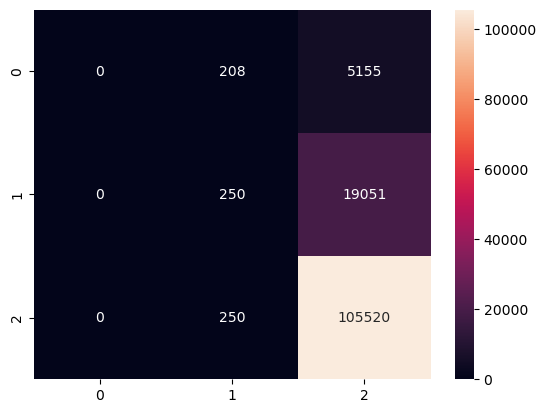

In [66]:
# Hyperparameter tuning random sampling

# accuracy as scoring metric
rand_search_ac.fit(x_train, y_train)
print(f"Best parameters for tuning on accuracy: {rand_search_ac.best_params_}")
SVM_result(rand_search_ac.best_estimator_, x_train, y_train, x_test, y_test)

Best parameters for tuning on f1: {'C': 4.620282385385153, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.35      0.01      0.02     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.39      0.34      0.31    130434
weighted avg       0.71      0.81      0.73    130434



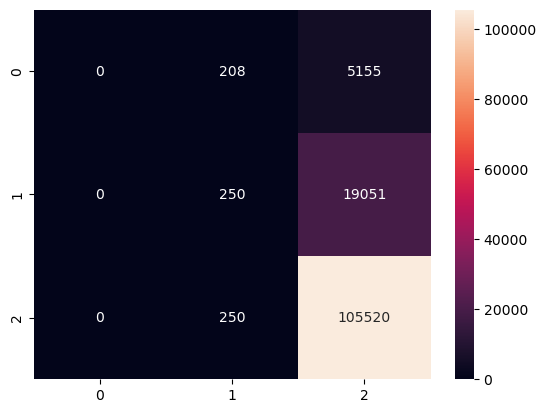

In [67]:
# f1 as scoring metric
rand_search_f1.fit(x_train, y_train) 
print(f"Best parameters for tuning on f1: {rand_search_f1.best_params_}")
SVM_result(rand_search_f1.best_estimator_, x_train, y_train, x_test, y_test)

Best parameters for tuning on macro recall: {'C': 4.620282385385153, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.35      0.01      0.02     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.39      0.34      0.31    130434
weighted avg       0.71      0.81      0.73    130434



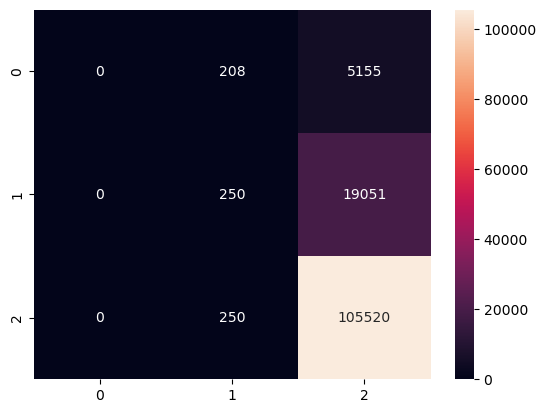

In [68]:
# macro-recall as scoring metric
rand_search_recall.fit(x_train, y_train) 
print(f"Best parameters for tuning on macro recall: {rand_search_recall.best_params_}")
SVM_result(rand_search_recall.best_estimator_, x_train, y_train, x_test, y_test)

### SVM for random under sampling

Best parameters for tuning on accuracy: {'C': 4.4882861322163485, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.07      0.53      0.12      5363
         1.0       0.18      0.16      0.17     19301
         2.0       0.85      0.56      0.68    105770

    accuracy                           0.50    130434
   macro avg       0.36      0.42      0.32    130434
weighted avg       0.72      0.50      0.58    130434



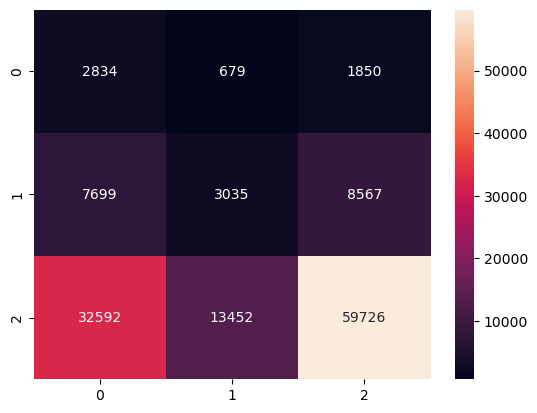

In [69]:
# Hyperparameter tuning under sampling

# accuracy as scoring metric
rand_search_ac.fit(x_rus, y_rus)
print(f"Best parameters for tuning on accuracy: {rand_search_ac.best_params_}")
SVM_result(rand_search_ac.best_estimator_, x_rus, y_rus, x_test, y_test)

Best parameters for tuning on f1: {'C': 4.4882861322163485, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.07      0.53      0.12      5363
         1.0       0.18      0.16      0.17     19301
         2.0       0.85      0.56      0.68    105770

    accuracy                           0.50    130434
   macro avg       0.36      0.42      0.32    130434
weighted avg       0.72      0.50      0.58    130434



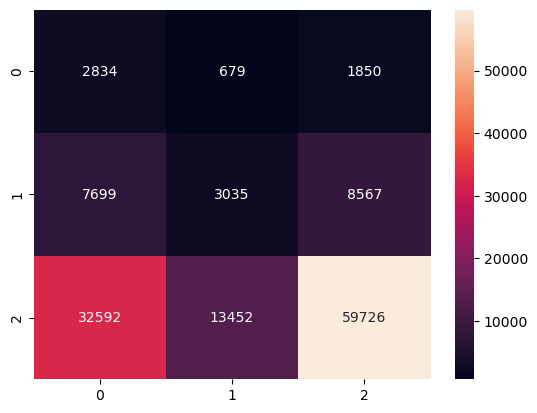

In [70]:
# f1 as scoring metric
rand_search_f1.fit(x_rus, y_rus) 
print(f"Best parameters for tuning on f1: {rand_search_f1.best_params_}")
SVM_result(rand_search_f1.best_estimator_, x_rus, y_rus, x_test, y_test)

Best parameters for tuning on macro recall: {'C': 4.4882861322163485, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.07      0.53      0.12      5363
         1.0       0.18      0.16      0.17     19301
         2.0       0.85      0.56      0.68    105770

    accuracy                           0.50    130434
   macro avg       0.36      0.42      0.32    130434
weighted avg       0.72      0.50      0.58    130434



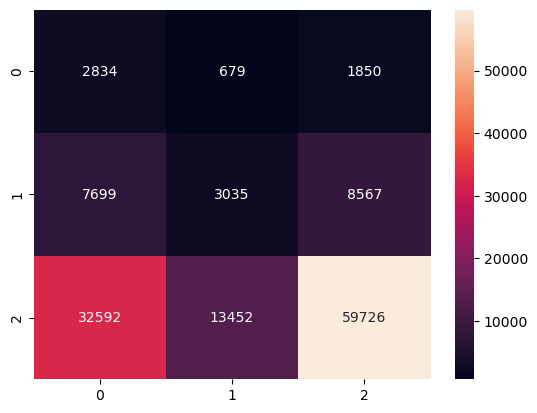

In [71]:
# macro-recall as scoring metric
rand_search_recall.fit(x_rus, y_rus) 
print(f"Best parameters for tuning on macro recall: {rand_search_recall.best_params_}")
SVM_result(rand_search_recall.best_estimator_, x_rus, y_rus, x_test, y_test)

### SVM for random over sampling

Best parameters for tuning on accuracy: {'C': 4.4882861322163485, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.07      0.53      0.12      5363
         1.0       0.18      0.15      0.16     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.37      0.42      0.32    130434
weighted avg       0.72      0.51      0.58    130434



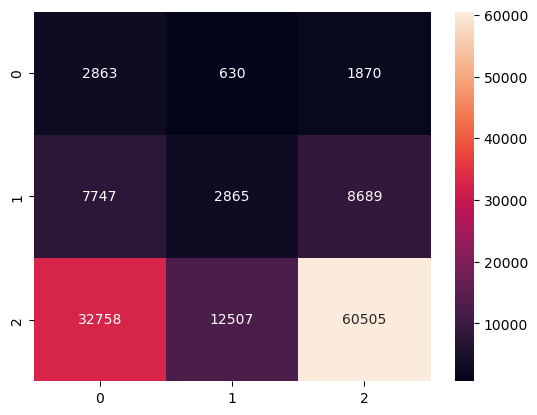

In [72]:
# Hyperparameter tuning over sampling

# accuracy as scoring metric
rand_search_ac.fit(x_ros, y_ros)
print(f"Best parameters for tuning on accuracy: {rand_search_ac.best_params_}")
SVM_result(rand_search_ac.best_estimator_, x_ros, y_ros, x_test, y_test)

Best parameters for tuning on f1: {'C': 0.04679306903882352, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.07      0.53      0.12      5363
         1.0       0.18      0.15      0.16     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.37      0.42      0.32    130434
weighted avg       0.72      0.51      0.58    130434



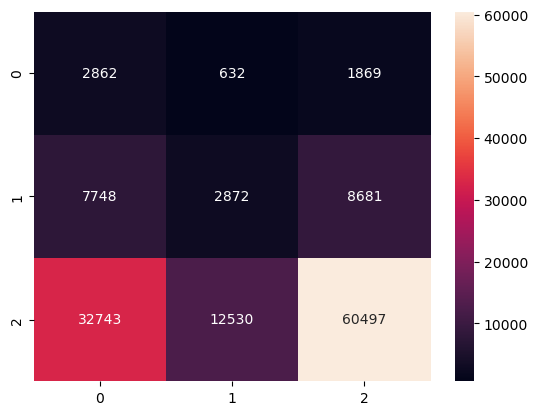

In [73]:
# f1 as scoring metric
rand_search_f1.fit(x_ros, y_ros) 
print(f"Best parameters for tuning on f1: {rand_search_f1.best_params_}")
SVM_result(rand_search_f1.best_estimator_, x_ros, y_ros, x_test, y_test)

Best parameters for tuning on macro recall: {'C': 4.4882861322163485, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.07      0.53      0.12      5363
         1.0       0.18      0.15      0.16     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.37      0.42      0.32    130434
weighted avg       0.72      0.51      0.58    130434



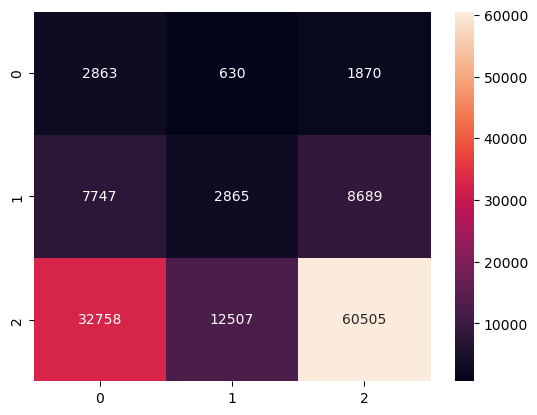

In [74]:
# macro-recall as scoring metric
rand_search_recall.fit(x_ros, y_ros) 
print(f"Best parameters for tuning on macro recall: {rand_search_recall.best_params_}")
SVM_result(rand_search_recall.best_estimator_, x_ros, y_ros, x_test, y_test)

### SVM for smote sampling

Best parameters for tuning on accuracy: {'C': 0.04679306903882352, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.06      0.54      0.12      5363
         1.0       0.18      0.16      0.17     19301
         2.0       0.85      0.56      0.67    105770

    accuracy                           0.50    130434
   macro avg       0.37      0.42      0.32    130434
weighted avg       0.72      0.50      0.57    130434



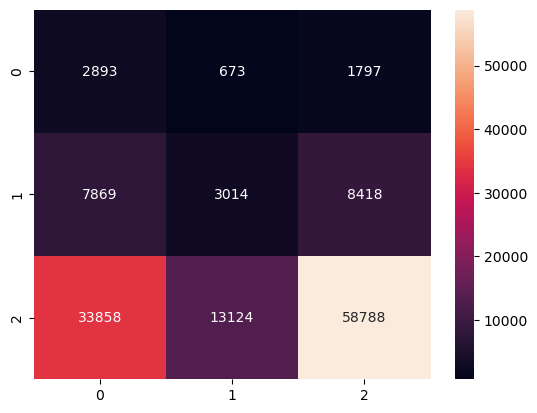

In [75]:
# Hyperparameter tuning after smote sampling

# accuracy as scoring metric
rand_search_ac.fit(x_smote, y_smote)
print(f"Best parameters for tuning on accuracy: {rand_search_ac.best_params_}")
SVM_result(rand_search_ac.best_estimator_, x_smote, y_smote, x_test, y_test)

Best parameters for tuning on f1: {'C': 0.04679306903882352, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.06      0.54      0.12      5363
         1.0       0.18      0.16      0.17     19301
         2.0       0.85      0.56      0.67    105770

    accuracy                           0.50    130434
   macro avg       0.37      0.42      0.32    130434
weighted avg       0.72      0.50      0.57    130434



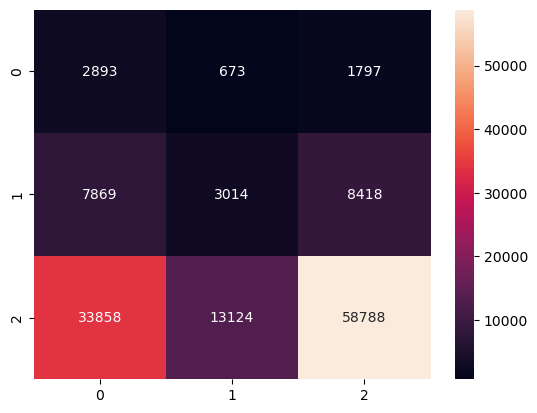

In [76]:
# f1 as scoring metric
rand_search_f1.fit(x_smote, y_smote) 
print(f"Best parameters for tuning on f1: {rand_search_f1.best_params_}")
SVM_result(rand_search_f1.best_estimator_, x_smote, y_smote, x_test, y_test)

Best parameters for tuning on macro recall: {'C': 0.04679306903882352, 'loss': 'squared_hinge'}
Result on test data:
              precision    recall  f1-score   support

         0.0       0.06      0.54      0.12      5363
         1.0       0.18      0.16      0.17     19301
         2.0       0.85      0.56      0.67    105770

    accuracy                           0.50    130434
   macro avg       0.37      0.42      0.32    130434
weighted avg       0.72      0.50      0.57    130434



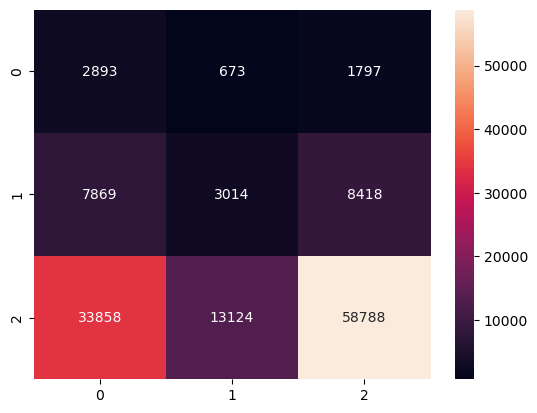

In [77]:
# macro-recall as scoring metric
rand_search_recall.fit(x_smote, y_smote) 
print(f"Best parameters for tuning on macro recall: {rand_search_recall.best_params_}")
SVM_result(rand_search_recall.best_estimator_, x_smote, y_smote, x_test, y_test)

## Logistic Regression Model

Motivation: The main reason we want to use logistic regression model with multiple classes is to set a reference for all other more complicated models to better evaluate their performances as logistic regression is the simplest one.

Metrics: Average Recall

Hyperparameters tuning: penalty: l1, l2, elasticnet (solver = saga)

class_weight: balanced or default

multi_class: multinomial (solver = saga), ovr (solver = liblinear)

l1_ratio: 0.2, 0.4, 0.6, 0.8

In [78]:
# Hyperparameters
penalty = ['l1', 'l2', 'elasticnet']
class_weight = ['balanced','']
multi_class = ['multinomial', 'ovr']
l1_ratio = [0.2, 0.4, 0.6, 0.8]

In [88]:
# function to fit and tune the model using simple grid search
def logReg(x_train, y_train, x_val, y_val, penalty, weight, multi, l1_ratio):

    target_names = ['Poor', 'Fair', 'Good']
    report = {}
    best_recall = 0

    model = LogisticRegression(penalty='l2',
                               class_weight='balanced',
                               multi_class=multi[1],
                               solver='liblinear')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    model_report = classification_report(y_val,
                                         y_pred,
                                         target_names=target_names,
                                         output_dict=True)
    report["l2, balanced, ovr"] = model_report
    if model_report['macro avg']['recall'] > best_recall:
        best_model = model
        best_recall = model_report['macro avg']['recall']

    model = LogisticRegression(penalty='l2',
                               class_weight='',
                               multi_class=multi[1],
                               solver='liblinear')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    model_report = classification_report(y_val,
                                         y_pred,
                                         target_names=target_names,
                                         output_dict=True)
    report["l2, , ovr"] = model_report
    if model_report['macro avg']['recall'] > best_recall:
        best_model = model
        best_recall = model_report['macro avg']['recall']

    for i in penalty:
        for j in weight:
            tracker = 0
            if i != 'elasticnet':
                model = LogisticRegression(penalty=i,
                                           class_weight=j,
                                           multi_class=multi[0],
                                           solver='saga')
            else:
                while tracker != len(l1_ratio):
                    model = LogisticRegression(penalty=i,
                                               class_weight=j,
                                               multi_class=multi[0],
                                               solver='saga',
                                               l1_ratio=l1_ratio[tracker])
                    model.fit(x_train, y_train)
                    y_pred = model.predict(x_val)
                    label = i + ", " + j + ", multinomial, " + str(
                        l1_ratio[tracker])
                    model_report = classification_report(
                        y_val,
                        y_pred,
                        target_names=target_names,
                        output_dict=True)
                    report[label] = model_report
                    if model_report['macro avg']['recall'] > best_recall:
                        best_model = model
                        best_recall = model_report['macro avg']['recall']
                    tracker += 1
                continue

            model.fit(x_train, y_train)
            y_pred = model.predict(x_val)
            label = i + ", " + j + ", multinomial"
            model_report = classification_report(y_val,
                                                 y_pred,
                                                 target_names=target_names,
                                                 output_dict=True)
            report[label] = model_report
            if model_report['macro avg']['recall'] > best_recall:
                best_model = model
                best_recall = model_report['macro avg']['recall']

    return best_model, report

In [89]:
# function to evaluate the model
def model_result(report):
    best_recall = 0
    best_accuracy = 0
    best_f1_score = 0
    for params, metrics in report.items():
        # weighted recall on validation set
        avg_recall = metrics['macro avg']['recall']
        # accuracy on validation set
        accuracy = metrics['accuracy']
        # f1 score on validation set
        f1_score = metrics['macro avg']['f1-score']

        if best_recall < avg_recall:
            best_recall = avg_recall
            best_params_recall = params
        if best_accuracy < accuracy:
            best_accuracy = accuracy
            best_params_accuracy = params
        if best_f1_score < f1_score:
            best_f1_score = f1_score
            best_params_f1_score = params

    print("Accuracy as metric for hyperparamter tuning:")
    print("Optimal Hyperparameters: ", best_params_accuracy)
    print("Optimal accuracy score: ", best_accuracy)

    print()
    print("F1 score as metric for hyperparamter tuning:")
    print("Optimal Hyperparameters: ", best_params_f1_score)
    print("Optimal F1 score: ", best_f1_score)

    print()
    print("Macro recall as metric for hyperparamter tuning:")
    print("Optimal Hyperparameters: ", best_params_recall)
    print("Optimal macro recall score: ", best_recall)

### LR for random stratified sampling

Accuracy as metric for hyperparamter tuning:
Optimal Hyperparameters:  l1, , multinomial
Optimal accuracy score:  0.8110265649557251

F1 score as metric for hyperparamter tuning:
Optimal Hyperparameters:  elasticnet, balanced, multinomial, 0.6
Optimal F1 score:  0.3667133915320077

Macro recall as metric for hyperparamter tuning:
Optimal Hyperparameters:  elasticnet, balanced, multinomial, 0.4
Optimal macro recall score:  0.3833392717227006
Average recall on test dataset:  0.3764022016584548


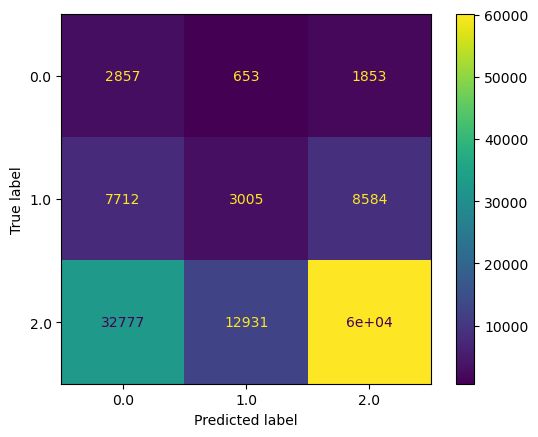

In [90]:
# random stratified sampling
best_model_random, report_random = logReg(x_train, y_train, x_val, y_val,
                                          penalty, class_weight, multi_class,
                                          l1_ratio)
# evaluate the model
model_result(report_random)
# recall score on test set using best_recall_params
y_pred = best_model_random.predict(x_test)
test_score = recall_score(y_test, y_pred, average='macro')
print("Average recall on test dataset: ", test_score)

plot_confusion_matrix(model, x_test, y_test)
plt.show()

### LR for random over sampling

Accuracy as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal accuracy score:  0.5049545750757082

F1 score as metric for hyperparamter tuning:
Optimal Hyperparameters:  l1, balanced, multinomial
Optimal F1 score:  0.3241342334017288

Macro recall as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal macro recall score:  0.4227742513010136
Average recall on test dataset:  0.41875680523612324


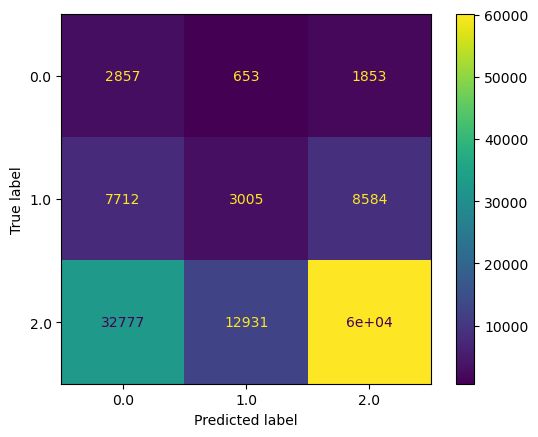

In [91]:
# Over sampling
best_model_ros, report_ros = logReg(x_ros, y_ros, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)
# evaluate the model
model_result(report_ros)
# recall score on test set using best_recall_params
y_pred = best_model_ros.predict(x_test)
test_score = recall_score(y_test, y_pred, average='macro')
print("Average recall on test dataset: ", test_score)

plot_confusion_matrix(model, x_test, y_test)
plt.show()

### LR for random under sampling

Accuracy as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal accuracy score:  0.4998658335569441

F1 score as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal F1 score:  0.32217264363906756

Macro recall as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal macro recall score:  0.42284372522484315
Average recall on test dataset:  0.41724907382348886


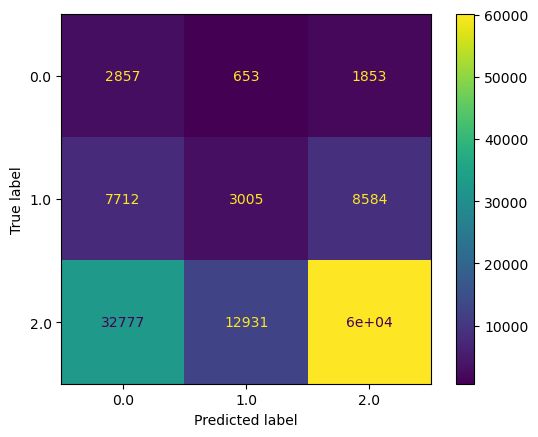

In [92]:
# Under sampling
best_model_rus, report_rus = logReg(x_rus, y_rus, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)
# evaluate the model
model_result(report_rus)
# recall score on test set using best_recall_params
y_pred = best_model_rus.predict(x_test)
test_score = recall_score(y_test, y_pred, average='macro')
print("Average recall on test dataset: ", test_score)

plot_confusion_matrix(model, x_test, y_test)
plt.show()

### LR for smote sampling

Accuracy as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal accuracy score:  0.5049545750757082

F1 score as metric for hyperparamter tuning:
Optimal Hyperparameters:  l1, , multinomial
Optimal F1 score:  0.3241342334017288

Macro recall as metric for hyperparamter tuning:
Optimal Hyperparameters:  l2, balanced, ovr
Optimal macro recall score:  0.4227742513010136
Average recall on test dataset:  0.41875680523612324


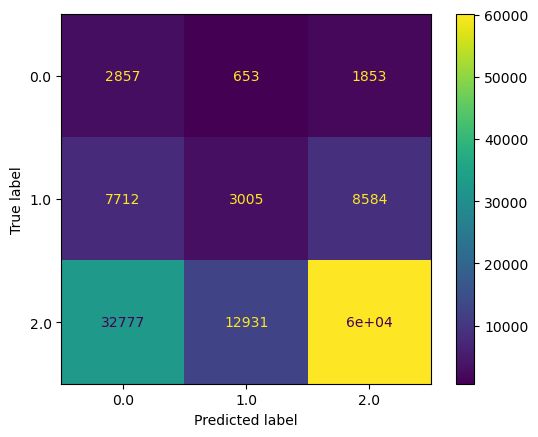

In [93]:
## SMOTE on train data
best_model_smote, report_smote = logReg(x_ros, y_ros, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)
# evaluate the model
model_result(report_smote)
# recall score on test set using best_recall_params
y_pred = best_model_smote.predict(x_test)
test_score = recall_score(y_test, y_pred, average='macro')
print("Average recall on test dataset: ", test_score)

plot_confusion_matrix(model, x_test, y_test)
plt.show()

###  LR: Features importance analysis

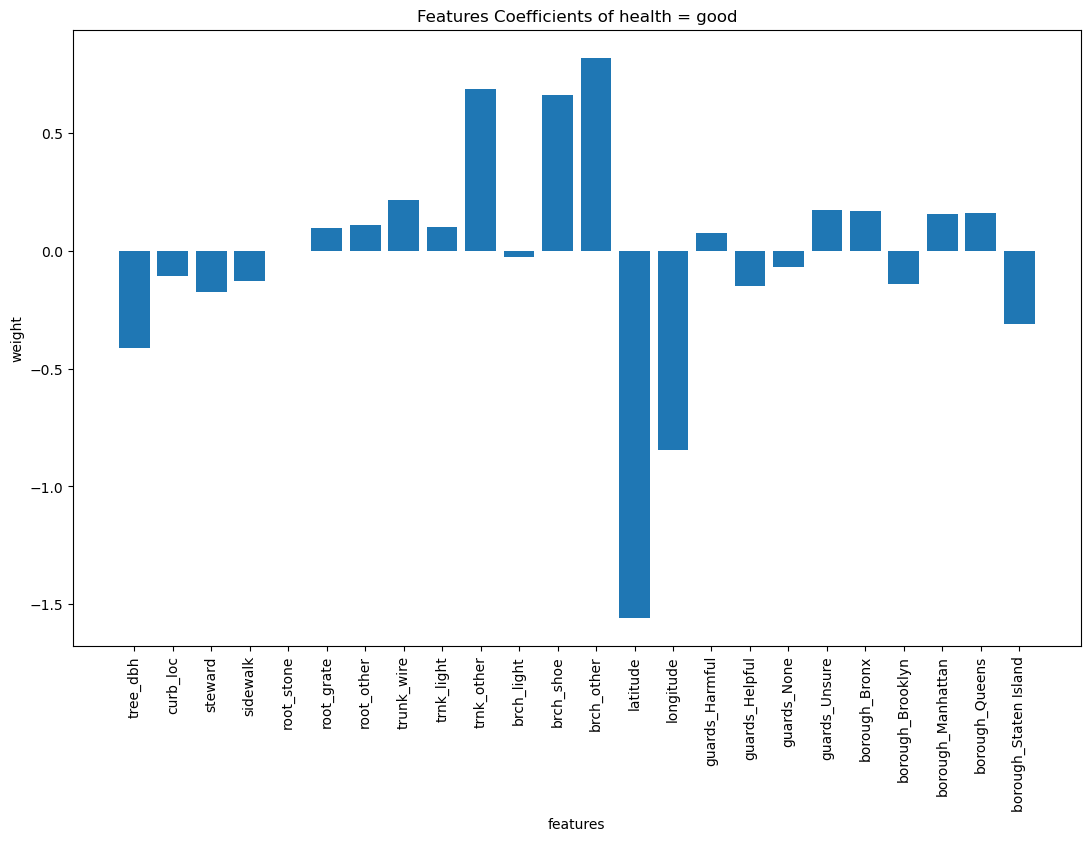

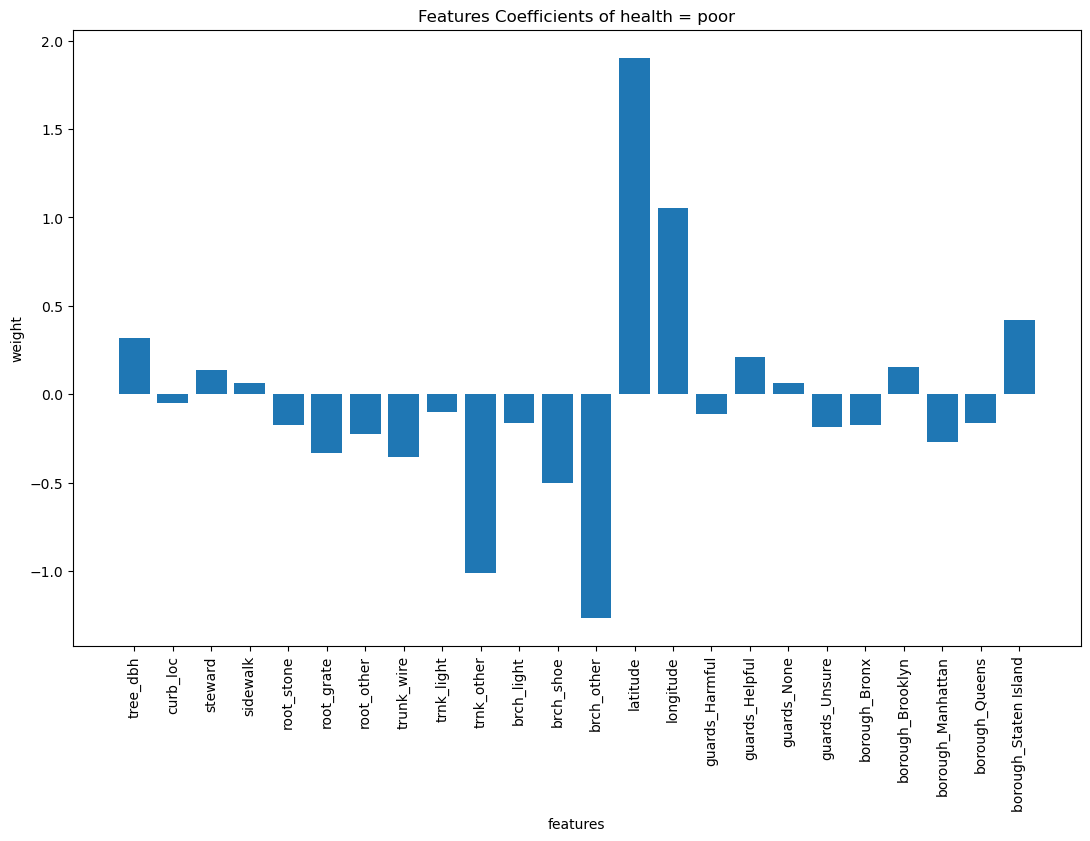

In [94]:
# Features importance analysis
# Best Model is using SMOTE sampling
# Features Coefficients of health = good
plt.figure(figsize=(13, 8))
plt.bar(x= x_train.columns, height=best_model_smote.coef_[0])
plt.title("Features Coefficients of health = good")
plt.xlabel('features')
plt.xticks(rotation=90)
plt.ylabel('weight')
plt.show()

# Features Coefficients of health = poor
plt.figure(figsize=(13, 8))
plt.bar(x= x_train.columns, height=best_model_smote.coef_[2])
plt.title("Features Coefficients of health = poor")
plt.xlabel('features')
plt.xticks(rotation=90)
plt.ylabel('weight')
plt.show()

## Random Forest

### Hyper-parameter tuning

In [28]:
rf_params = {
    'max_depth': np.linspace(1, 68, 68, dtype=int),
    'n_estimators': np.linspace(20, 100, 81, dtype=int)
}

In [30]:
def hyperparams_rfc(scoring_method, params, x, y):
    rfc = RandomForestClassifier()
    cv = RandomizedSearchCV(rfc, params, n_jobs=8, scoring=scoring_method, verbose=2)
    cv.fit(x, y)
    return cv.best_params_

In [ ]:
accuracy_strat_params = hyperparams_rfc('accuracy', rf_params, x_train, y_train)
f1_strat_params = hyperparams_rfc('f1_macro', rf_params, x_train, y_train)
recall_strat_params = hyperparams_rfc('recall_macro', rf_params, x_train, y_train)

In [35]:
print("Accuracy-trained stratified best params:", accuracy_strat_params)
print("F1-trained stratified best params:", f1_strat_params)
print("Recall-trained stratified best params:", recall_strat_params)

Accuracy-trained stratified best params: {'n_estimators': 37, 'max_depth': 24}
F1-trained stratified best params: {'n_estimators': 53, 'max_depth': 56}
Recall-trained stratified best params: {'n_estimators': 32, 'max_depth': 58}


In [ ]:
accuracy_over_params = hyperparams_rfc('accuracy', rf_params, x_ros, y_ros)
f1_over_params = hyperparams_rfc('f1_macro', rf_params, x_ros, y_ros)
recall_over_params = hyperparams_rfc('recall_macro', rf_params, x_ros, y_ros)

In [36]:
print("Accuracy-trained over-sampled best params:", accuracy_over_params)
print("F1-trained over-sampled best params:", f1_over_params)
print("Recall-trained over-sampled best params:", recall_over_params)

Accuracy-trained over-sampled best params: {'n_estimators': 94, 'max_depth': 50}
F1-trained over-sampled best params: {'n_estimators': 74, 'max_depth': 48}
Recall-trained over-sampled best params: {'n_estimators': 99, 'max_depth': 42}


In [ ]:
accuracy_under_params = hyperparams_rfc('accuracy', rf_params, x_rus, y_rus)
f1_under_params = hyperparams_rfc('f1_macro', rf_params, x_rus, y_rus)
recall_under_params = hyperparams_rfc('recall_macro', rf_params, x_rus, y_rus)

In [37]:
print("Accuracy-trained under-sampled best params:", accuracy_under_params)
print("F1-trained under-sampled best params:", f1_under_params)
print("Recall-trained under-sampled best params:", recall_under_params)

Accuracy-trained under-sampled best params: {'n_estimators': 48, 'max_depth': 20}
F1-trained under-sampled best params: {'n_estimators': 83, 'max_depth': 29}
Recall-trained under-sampled best params: {'n_estimators': 85, 'max_depth': 22}


In [ ]:
accuracy_smote_params = hyperparams_rfc('accuracy', rf_params, x_smote, y_smote)
f1_smote_params = hyperparams_rfc('f1_macro', rf_params, x_smote, y_smote)
recall_smote_params = hyperparams_rfc('recall_macro', rf_params, x_smote, y_smote)

In [38]:
print("Accuracy-trained SMOTE-sampled best params:", accuracy_smote_params)
print("F1-trained SMOTE-sampled best params:", f1_smote_params)
print("Recall-trained SMOTE-sampled best params:", recall_smote_params)

Accuracy-trained SMOTE-sampled best params: {'n_estimators': 86, 'max_depth': 67}
F1-trained SMOTE-sampled best params: {'n_estimators': 79, 'max_depth': 54}
Recall-trained SMOTE-sampled best params: {'n_estimators': 67, 'max_depth': 61}


### Training

In [41]:
def train_rfc(params, x, y, x_test, y_test):
    rfc = RandomForestClassifier(**params)
    rfc.fit(x, y)
    y_train_pred = rfc.predict(x)
    y_test_pred = rfc.predict(x_test)
    
    y_train_acc = accuracy_score(y, y_train_pred)
    y_test_acc = accuracy_score(y_test, y_test_pred)
    
    print("\tTrain accuracy:", y_train_acc)
    print("\tTest accuracy:", y_test_acc)
    
    y_train_f1 = f1_score(y, y_train_pred, average='weighted')
    y_test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    print("\tTrain F1:", y_train_f1)
    print("\tTest F1:", y_test_f1)
    
    y_train_recall = recall_score(y, y_train_pred, average='weighted')
    y_test_recall = recall_score(y_test, y_test_pred, average='weighted')
    
    print("\tTrain Recall:", y_train_recall)
    print("\tTest Recall:", y_test_recall)
    
    return rfc

In [42]:
print("Accuracy-trained stratified RFC:")
accuracy_strat_rfc = train_rfc(accuracy_strat_params, x_train, y_train, x_test, y_test)

print()
print("F1-trained stratified RFC:")
f1_strat_rfc = train_rfc(f1_strat_params, x_train, y_train, x_test, y_test)

print()
print("Recall-trained stratified RFC:")
recall_strat_rfc = train_rfc(recall_strat_params, x_train, y_train, x_test, y_test)

Accuracy-trained stratified RFC:
	Train accuracy: 0.866026335208487
	Test accuracy: 0.8148642225186684
	Train F1: 0.8344836350160387
	Test F1: 0.7536562997666715
	Train Recall: 0.866026335208487
	Test Recall: 0.8148642225186684

F1-trained stratified RFC:
	Train accuracy: 0.9993650991403682
	Test accuracy: 0.8070901758743886
	Train F1: 0.9993647012971065
	Test F1: 0.770991498232546
	Train Recall: 0.9993650991403682
	Test Recall: 0.8070901758743886

Recall-trained stratified RFC:
	Train accuracy: 0.998083318159602
	Test accuracy: 0.8047441617983041
	Train F1: 0.9980797395975427
	Test F1: 0.7707027487334643
	Train Recall: 0.998083318159602
	Test Recall: 0.8047441617983041


In [43]:
print("Accuracy-trained over-sampled RFC:")
accuracy_over_rfc = train_rfc(accuracy_over_params, x_ros, y_ros, x_test, y_test)

print()
print("F1-trained over-sampled RFC:")
f1_over_rfc = train_rfc(f1_over_params, x_ros, y_ros, x_test, y_test)

print()
print("Recall-trained over-sampled RFC:")
recall_over_rfc = train_rfc(recall_over_params, x_ros, y_ros, x_test, y_test)

Accuracy-trained over-sampled RFC:
	Train accuracy: 0.9999793182711256
	Test accuracy: 0.7767913274146312
	Train F1: 0.9999793182449315
	Test F1: 0.762297366888763
	Train Recall: 0.9999793182711256
	Test Recall: 0.7767913274146312

F1-trained over-sampled RFC:
	Train accuracy: 0.9999724243615009
	Test accuracy: 0.7768066608399651
	Train F1: 0.9999724242669156
	Test F1: 0.7622068169842827
	Train Recall: 0.9999724243615009
	Test Recall: 0.7768066608399651

Recall-trained over-sampled RFC:
	Train accuracy: 0.9999576516980192
	Test accuracy: 0.7780563350046767
	Train F1: 0.9999576515291584
	Test F1: 0.7632819628224394
	Train Recall: 0.9999576516980192
	Test Recall: 0.7780563350046767


In [44]:
print("Accuracy-trained under-sampled RFC:")
accuracy_under_rfc = train_rfc(accuracy_under_params, x_rus, y_rus, x_test, y_test)

print()
print("F1-trained under-sampled RFC:")
f1_under_rfc = train_rfc(f1_under_params, x_rus, y_rus, x_test, y_test)

print()
print("Recall-trained under-sampled RFC:")
recall_under_rfc = train_rfc(recall_under_params, x_rus, y_rus, x_test, y_test)

Accuracy-trained under-sampled RFC:
	Train accuracy: 0.7858765950008739
	Test accuracy: 0.545202937884294
	Train F1: 0.7862050428380374
	Test F1: 0.6145027404720691
	Train Recall: 0.7858765950008739
	Test Recall: 0.545202937884294

F1-trained under-sampled RFC:
	Train accuracy: 0.9853172522286313
	Test accuracy: 0.5055660333962004
	Train F1: 0.9853310474392671
	Test F1: 0.5814410010092865
	Train Recall: 0.9853172522286313
	Test Recall: 0.5055660333962004

Recall-trained under-sampled RFC:
	Train accuracy: 0.849268775855037
	Test accuracy: 0.5439149301562476
	Train F1: 0.8499633341973797
	Test F1: 0.6133554336170826
	Train Recall: 0.849268775855037
	Test Recall: 0.5439149301562476


In [45]:
print("Accuracy-trained SMOTE-sampled RFC:")
accuracy_smote_rfc = train_rfc(accuracy_smote_params, x_smote, y_smote, x_test, y_test)

print()
print("F1-trained SMOTE-sampled RFC:")
f1_smote_rfc = train_rfc(f1_smote_params, x_smote, y_smote, x_test, y_test)

print()
print("Recall-trained SMOTE-sampled RFC:")
recall_smote_rfc = train_rfc(recall_smote_params, x_smote, y_smote, x_test, y_test)

Accuracy-trained SMOTE-sampled RFC:
	Train accuracy: 0.9998965913556283
	Test accuracy: 0.6606636306484506
	Train F1: 0.9998965918181536
	Test F1: 0.6966946694220851
	Train Recall: 0.9998965913556283
	Test Recall: 0.6606636306484506

F1-trained SMOTE-sampled RFC:
	Train accuracy: 0.999876894470986
	Test accuracy: 0.6603952957051076
	Train F1: 0.9998768950773091
	Test F1: 0.6963869009264033
	Train Recall: 0.999876894470986
	Test Recall: 0.6603952957051076

Recall-trained SMOTE-sampled RFC:
	Train accuracy: 0.9998375007017015
	Test accuracy: 0.6591992885290645
	Train F1: 0.9998375007724538
	Test F1: 0.6954881973787584
	Train Recall: 0.9998375007017015
	Test Recall: 0.6591992885290645


### Evaluation

In [46]:
def conf_matrix_and_scores(rfc, title):
    plot_confusion_matrix(rfc, x_test, y_test)
    plt.title(title)
    plt.show()
    
    y_test_pred = rfc.predict(x_test)
    
    print(classification_report(y_test, y_test_pred))

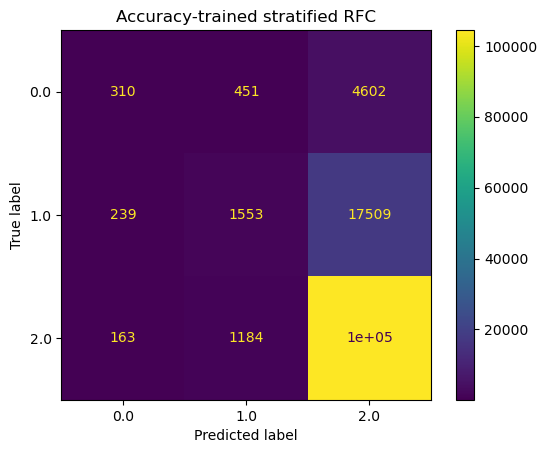

              precision    recall  f1-score   support

         0.0       0.44      0.06      0.10      5363
         1.0       0.49      0.08      0.14     19301
         2.0       0.83      0.99      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.58      0.38      0.38    130434
weighted avg       0.76      0.81      0.75    130434



In [47]:
conf_matrix_and_scores(accuracy_strat_rfc, "Accuracy-trained stratified RFC")

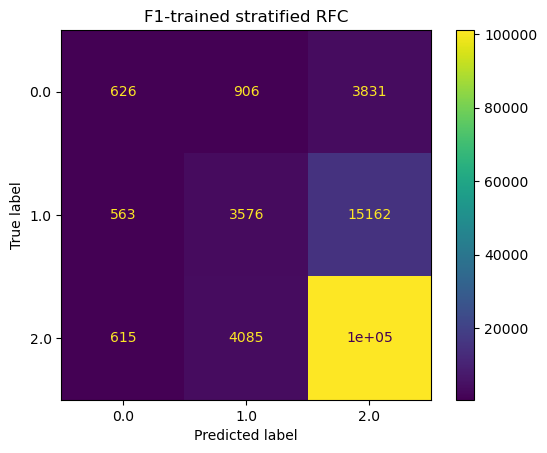

              precision    recall  f1-score   support

         0.0       0.35      0.12      0.17      5363
         1.0       0.42      0.19      0.26     19301
         2.0       0.84      0.96      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.54      0.42      0.44    130434
weighted avg       0.76      0.81      0.77    130434



In [48]:
conf_matrix_and_scores(f1_strat_rfc, "F1-trained stratified RFC")

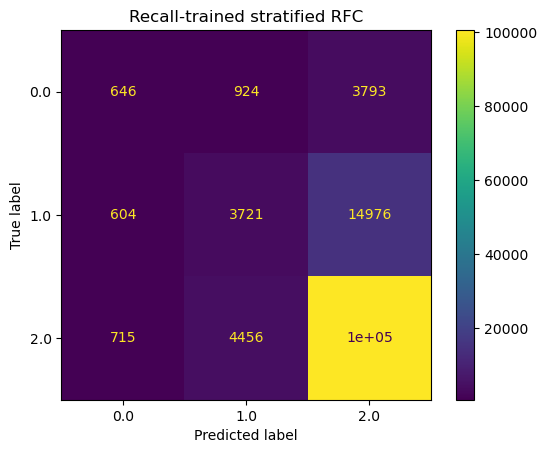

              precision    recall  f1-score   support

         0.0       0.33      0.12      0.18      5363
         1.0       0.41      0.19      0.26     19301
         2.0       0.84      0.95      0.89    105770

    accuracy                           0.80    130434
   macro avg       0.53      0.42      0.44    130434
weighted avg       0.76      0.80      0.77    130434



In [49]:
conf_matrix_and_scores(recall_strat_rfc, "Recall-trained stratified RFC")

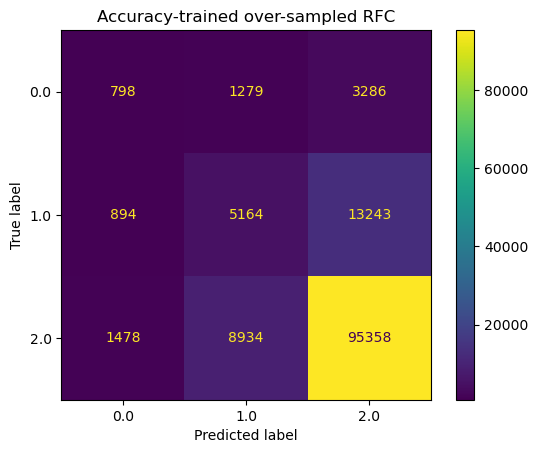

              precision    recall  f1-score   support

         0.0       0.25      0.15      0.19      5363
         1.0       0.34      0.27      0.30     19301
         2.0       0.85      0.90      0.88    105770

    accuracy                           0.78    130434
   macro avg       0.48      0.44      0.45    130434
weighted avg       0.75      0.78      0.76    130434



In [50]:
conf_matrix_and_scores(accuracy_over_rfc, "Accuracy-trained over-sampled RFC")

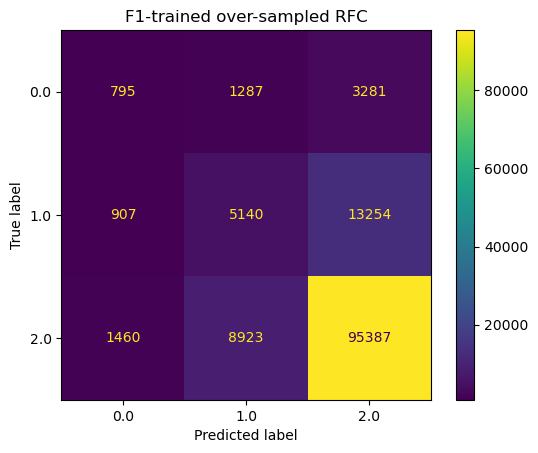

              precision    recall  f1-score   support

         0.0       0.25      0.15      0.19      5363
         1.0       0.33      0.27      0.30     19301
         2.0       0.85      0.90      0.88    105770

    accuracy                           0.78    130434
   macro avg       0.48      0.44      0.45    130434
weighted avg       0.75      0.78      0.76    130434



In [51]:
conf_matrix_and_scores(f1_over_rfc, "F1-trained over-sampled RFC")

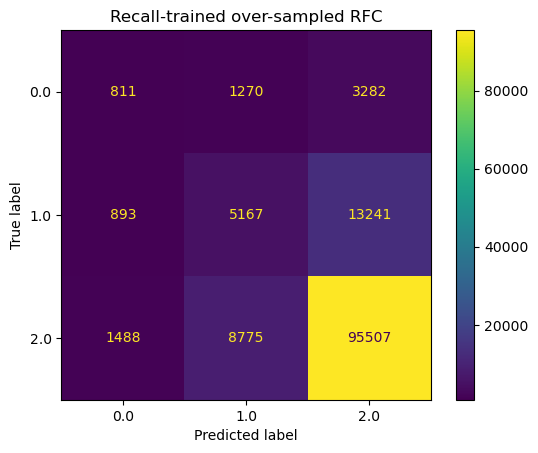

              precision    recall  f1-score   support

         0.0       0.25      0.15      0.19      5363
         1.0       0.34      0.27      0.30     19301
         2.0       0.85      0.90      0.88    105770

    accuracy                           0.78    130434
   macro avg       0.48      0.44      0.46    130434
weighted avg       0.75      0.78      0.76    130434



In [95]:
conf_matrix_and_scores(recall_over_rfc, "Recall-trained over-sampled RFC")

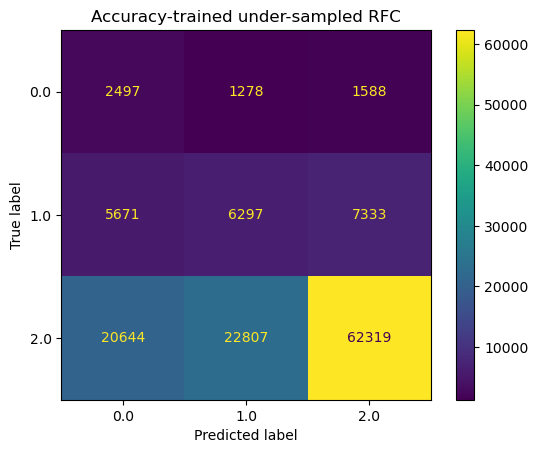

              precision    recall  f1-score   support

         0.0       0.09      0.47      0.15      5363
         1.0       0.21      0.33      0.25     19301
         2.0       0.87      0.59      0.70    105770

    accuracy                           0.55    130434
   macro avg       0.39      0.46      0.37    130434
weighted avg       0.74      0.55      0.61    130434



In [53]:
conf_matrix_and_scores(accuracy_under_rfc, "Accuracy-trained under-sampled RFC")

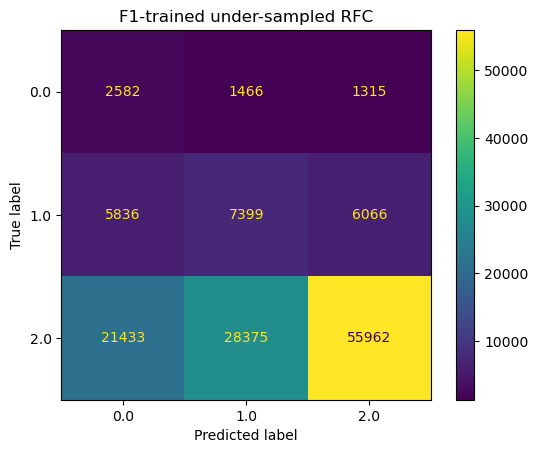

              precision    recall  f1-score   support

         0.0       0.09      0.48      0.15      5363
         1.0       0.20      0.38      0.26     19301
         2.0       0.88      0.53      0.66    105770

    accuracy                           0.51    130434
   macro avg       0.39      0.46      0.36    130434
weighted avg       0.75      0.51      0.58    130434



In [54]:
conf_matrix_and_scores(f1_under_rfc, "F1-trained under-sampled RFC")

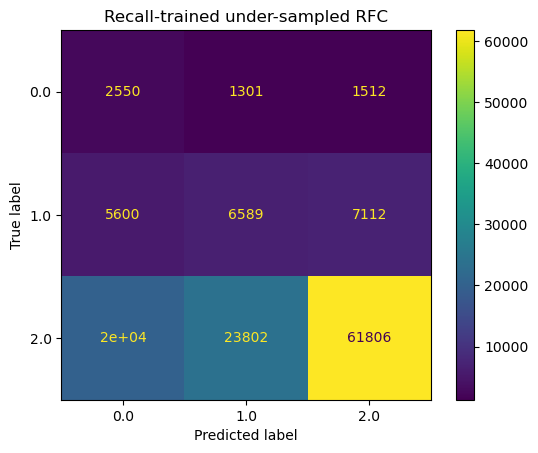

              precision    recall  f1-score   support

         0.0       0.09      0.48      0.15      5363
         1.0       0.21      0.34      0.26     19301
         2.0       0.88      0.58      0.70    105770

    accuracy                           0.54    130434
   macro avg       0.39      0.47      0.37    130434
weighted avg       0.75      0.54      0.61    130434



In [55]:
conf_matrix_and_scores(recall_under_rfc, "Recall-trained under-sampled RFC")

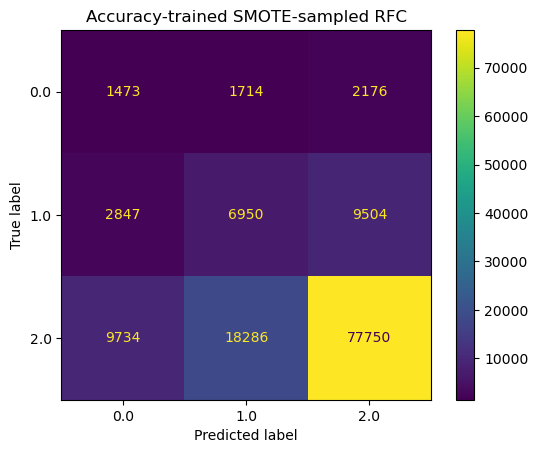

              precision    recall  f1-score   support

         0.0       0.10      0.27      0.15      5363
         1.0       0.26      0.36      0.30     19301
         2.0       0.87      0.74      0.80    105770

    accuracy                           0.66    130434
   macro avg       0.41      0.46      0.42    130434
weighted avg       0.75      0.66      0.70    130434



In [56]:
conf_matrix_and_scores(accuracy_smote_rfc, "Accuracy-trained SMOTE-sampled RFC")

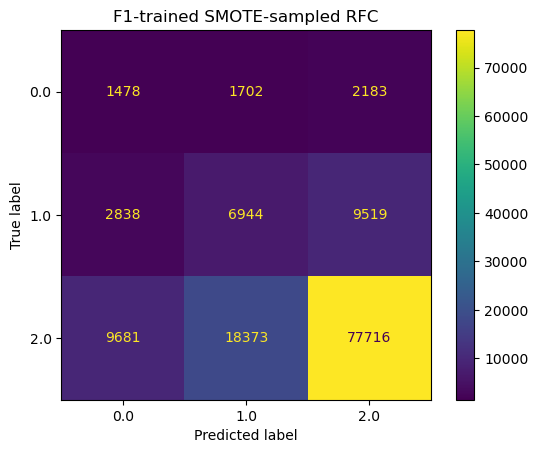

              precision    recall  f1-score   support

         0.0       0.11      0.28      0.15      5363
         1.0       0.26      0.36      0.30     19301
         2.0       0.87      0.73      0.80    105770

    accuracy                           0.66    130434
   macro avg       0.41      0.46      0.42    130434
weighted avg       0.75      0.66      0.70    130434



In [57]:
conf_matrix_and_scores(f1_smote_rfc, "F1-trained SMOTE-sampled RFC")

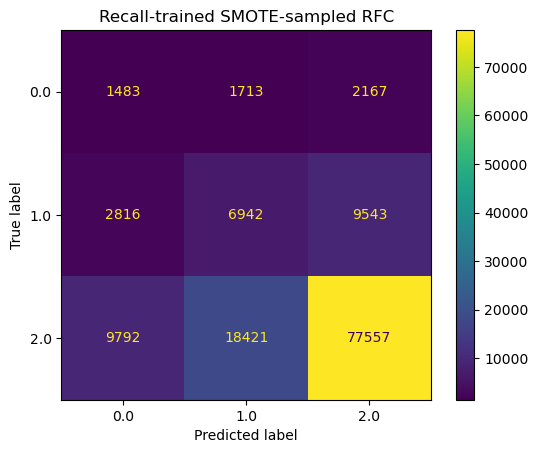

              precision    recall  f1-score   support

         0.0       0.11      0.28      0.15      5363
         1.0       0.26      0.36      0.30     19301
         2.0       0.87      0.73      0.80    105770

    accuracy                           0.66    130434
   macro avg       0.41      0.46      0.42    130434
weighted avg       0.75      0.66      0.70    130434



In [58]:
conf_matrix_and_scores(recall_smote_rfc, "Recall-trained SMOTE-sampled RFC")

The best model is the accuracy-trained over-sampled model.

In [59]:
def feat_importance(features, rfc):
    feat_imps = list(zip(features, rfc.feature_importances_))
    feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))
    ax = sns.barplot(x=list(imps), y=list(feats))
    ax.tick_params(axis='x', rotation=90)

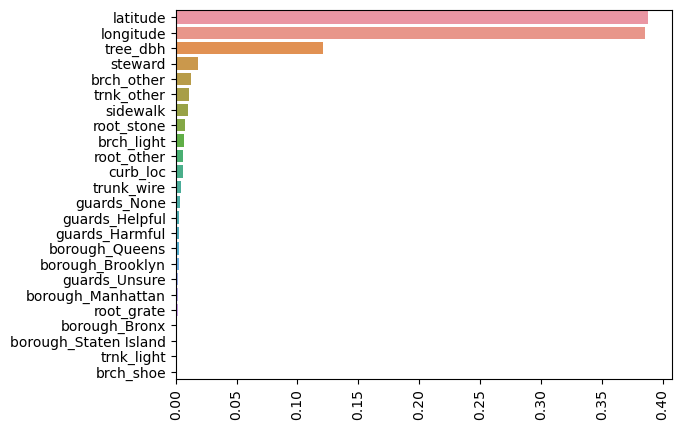

In [60]:
feat_importance(x_dev.columns, accuracy_over_rfc)